In [1]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.


In [2]:
DATA_DIR <- '../../data/Xy_year_split_data'
# DATA_DIR <- '../../data/Xy_internal_split_data'

In [3]:
merge.files <- function(set=c('train', 'valid', 'test')) {
  cat(sprintf('Merging %s data...\n', set))
  all.files <- list.files(DATA_DIR)
  X.files <- sort(all.files[grepl(paste('X', set, sep='_'), all.files)])
  y.files <- sort(all.files[grepl(paste('y', set, sep='_'), all.files)])
  X <- read.csv(paste(DATA_DIR, X.files[1], sep='/'))
  y <- read.csv(paste(DATA_DIR, y.files[1], sep='/'))
  data <- cbind(y, X)
  if (length(X.files) > 1) {
    for (i in 2:length(X.files)) {
      next.X <- read.csv(paste(DATA_DIR, X.files[i], sep='/'))
      next.y <- read.csv(paste(DATA_DIR, y.files[i], sep='/'))
      next.data <- cbind(next.y, next.X)
      data <- rbind(data, next.data)
    }
  }
  data
}

In [4]:
train <- merge.files('train')

Merging train data...


In [5]:
head(train)

btl_t x       y        lon       lat      etopo1 btl_t1 btl_t2 btl_t3 btl_t4
1 0     -450000 -2050000 -104.6710 31.34332 1182   0      0      0      0     
2 0     -440000 -2050000 -104.5674 31.34856 1348   0      0      0      0     
3 0     -430000 -2050000 -104.4637 31.35367 1373   0      0      0      0     
4 0     -420000 -2050000 -104.3601 31.35868 1338   0      0      0      0     
5 0     -410000 -2050000 -104.2564 31.36356 1154   0      0      0      0     
6 0     -400000 -2050000 -104.1527 31.36833 1049   0      0      0      0     
  ⋯ TOctSep  summerP1 summerP2 Pmean    POctSep  PcumOctSep PPT      ddAugJul
1 ⋯ 18.70993 166.3777 312.9212 19.50030 344.5293 530.5843   1448.361 6269.867
2 ⋯ 17.69212 182.0690 342.9087 21.44909 372.8566 583.3259   1593.923 5890.917
3 ⋯ 17.49928 182.7300 342.8194 21.11196 373.4863 580.9919   1590.416 5807.879
4 ⋯ 17.70641 177.3618 330.6562 19.85477 363.1089 556.6613   1532.920 5868.033
5 ⋯ 18.52186 162.9656 300.4217 17.81199 342.7247 513.7844   1416.045 6147.666
6 ⋯ 18.98397 150.5326 276.4537 16.42245 324.7968 481.8513   1336.997 6296.327
  ddAugJun year
1 5441.910 2000
2 5099.744 2000
3 5024.360 2000
4 5079.429 2000
5 5328.940 2000
6 5460.509 2000

In [6]:
for (j in 1:ncol(train)) {
  cat(sprintf('%11s: %s (%d)\n', 
              names(train)[j], 
              class(train[, j]), 
              length(unique(train[, j]))))
}

      btl_t: integer (2)
          x: numeric (196)
          y: numeric (361)
        lon: numeric (55082)
        lat: numeric (55082)
     etopo1: integer (3399)
     btl_t1: integer (2)
     btl_t2: integer (2)
     btl_t3: integer (2)
     btl_t4: integer (2)
     btl_t5: integer (2)
        vgt: integer (2)
    sum9_t1: integer (10)
    sum9_t2: integer (10)
    sum9_t3: integer (10)
    sum9_t4: integer (10)
    sum9_t5: integer (10)
    JanTmin: numeric (110134)
    MarTmin: numeric (110052)
    TMarAug: numeric (110164)
summerTmean: numeric (110146)
   AugTmean: numeric (110018)
    AugTmax: numeric (110131)
        GSP: numeric (109810)
    PMarAug: numeric (109946)
   summerP0: numeric (109764)
    OctTmin: numeric (109993)
  fallTmean: numeric (110149)
 winterTmin: numeric (109949)
       Tmin: numeric (110163)
      Tmean: numeric (110162)
       Tvar: numeric (110164)
    TOctSep: numeric (110161)
   summerP1: numeric (108383)
   summerP2: numeric (109881)
      Pmean: nu

In [7]:
#ignore <- c('btl_t', 'btl_t1', 'btl_t2', 'vgt', 'year', 'x', 'y')
ignore <- c('btl_t', 'btl_t1', 'btl_t2', 'btl_t3', 'btl_t4', 'btl_t5', 'vgt', 'year', 'x', 'y')
numeric.preds <- names(train)[which(!(names(train) %in% ignore))]
for (p in numeric.preds) {
  cat(sprintf('s(%s) + ', p))
}

s(lon) + s(lat) + s(etopo1) + s(sum9_t1) + s(sum9_t2) + s(sum9_t3) + s(sum9_t4) + s(sum9_t5) + s(JanTmin) + s(MarTmin) + s(TMarAug) + s(summerTmean) + s(AugTmean) + s(AugTmax) + s(GSP) + s(PMarAug) + s(summerP0) + s(OctTmin) + s(fallTmean) + s(winterTmin) + s(Tmin) + s(Tmean) + s(Tvar) + s(TOctSep) + s(summerP1) + s(summerP2) + s(Pmean) + s(POctSep) + s(PcumOctSep) + s(PPT) + s(ddAugJul) + s(ddAugJun) + 

In [8]:
dim(train)

[1] 110164     42

In [10]:
gam.sample <- function(n.sample) {
  start <- Sys.time()
  gam.mod <- gam(
    btl_t ~ s(lon) + s(lat) + s(etopo1) + s(sum9_t1) # + s(age) + s(density)
      + s(sum9_t2) + s(JanTmin) + s(MarTmin) + s(TMarAug) + s(summerTmean)
      + s(AugTmean) + s(AugTmax) + s(GSP) + s(PMarAug) + s(summerP0) 
      + s(OctTmin) + s(fallTmean) + s(winterTmin) + s(Tmin) + s(Tmean) 
      + s(Tvar) + s(TOctSep) + s(summerP1) + s(summerP2) + s(Pmean) 
      + s(POctSep) + s(PcumOctSep) + s(PPT) + s(ddAugJul) + s(ddAugJun),
    data=train[sample(nrow(train), n.sample), ],
    family='binomial')
  stop <- Sys.time()
  cat('Elapsed time:', stop - start, 's\n')
  gam.mod
}


Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
“Iteration limit reached without full convergence - check carefully”

Elapsed time: 13.46577 s


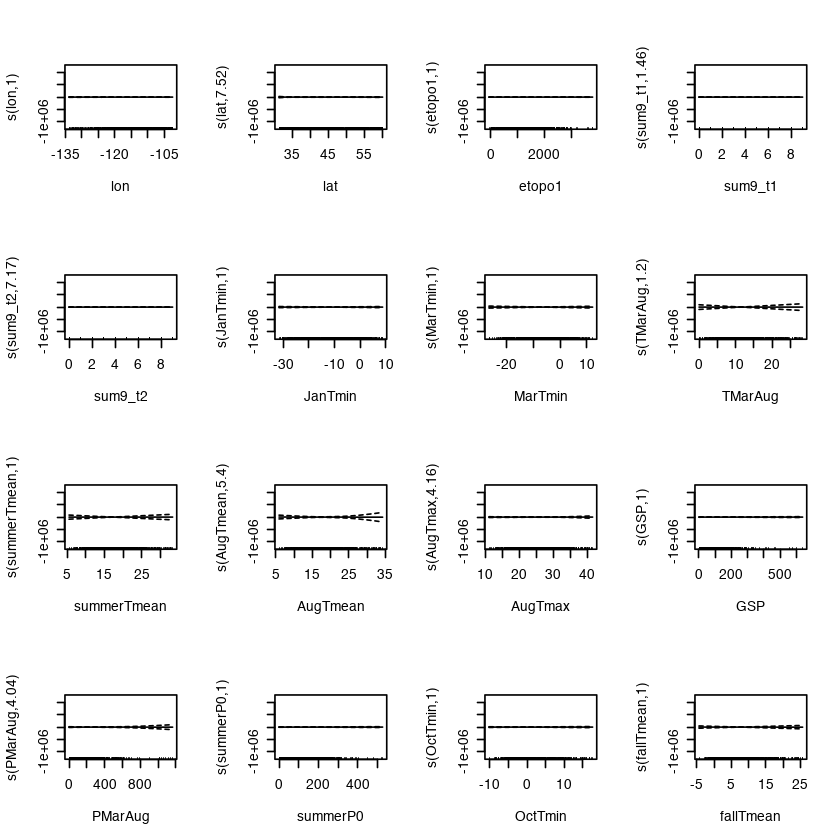

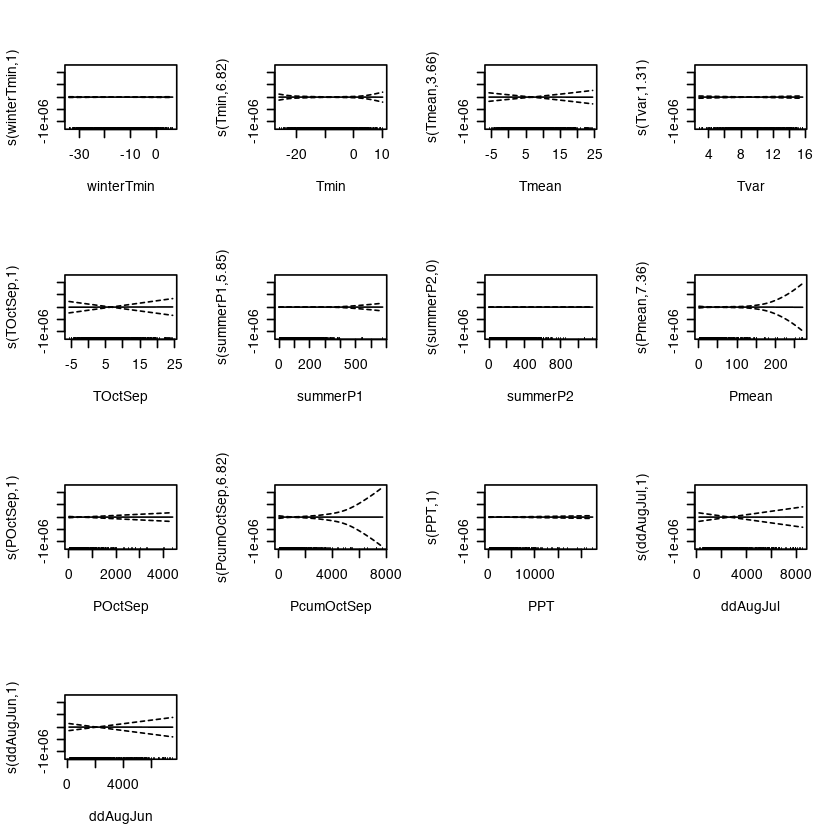

In [11]:
mod <- gam.sample(900)
par(mfrow=c(4, 4))
plot(mod)

Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
“Fitting terminated with step failure - check results carefully”

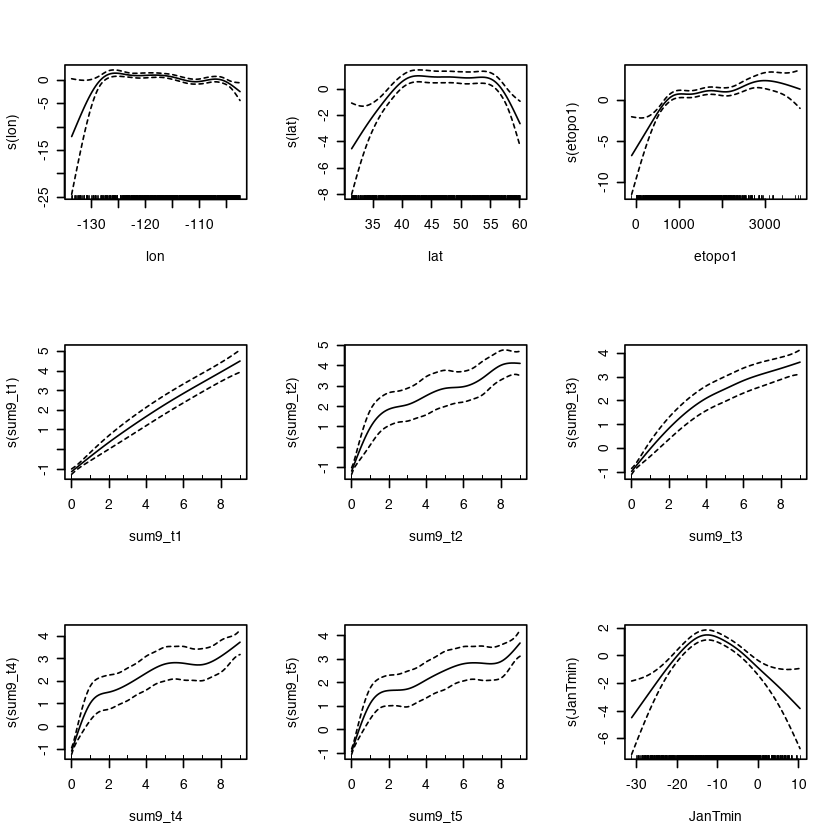

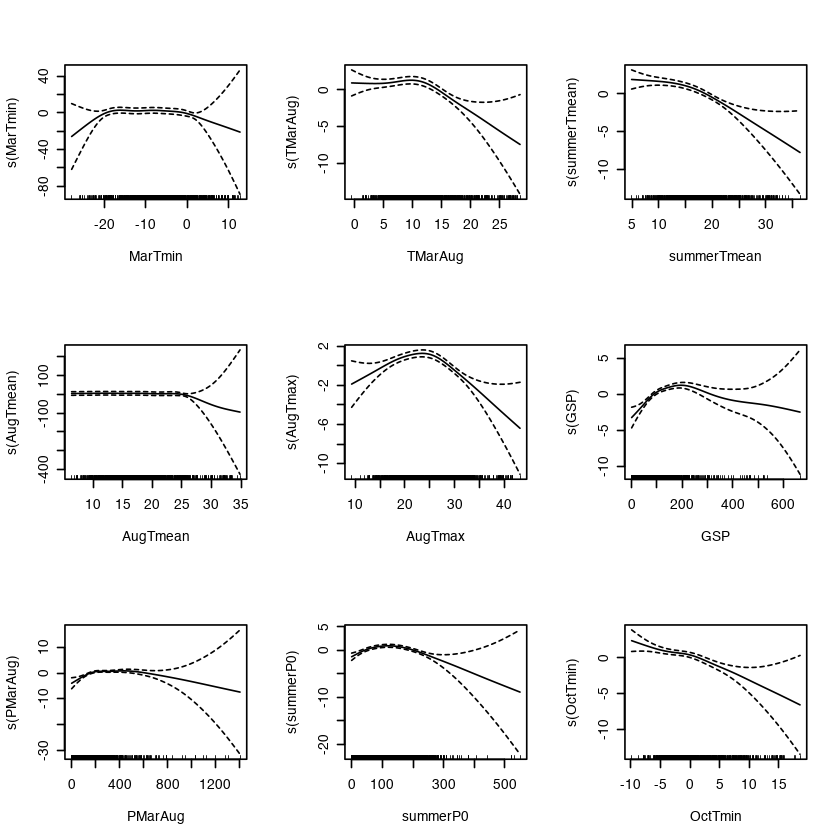

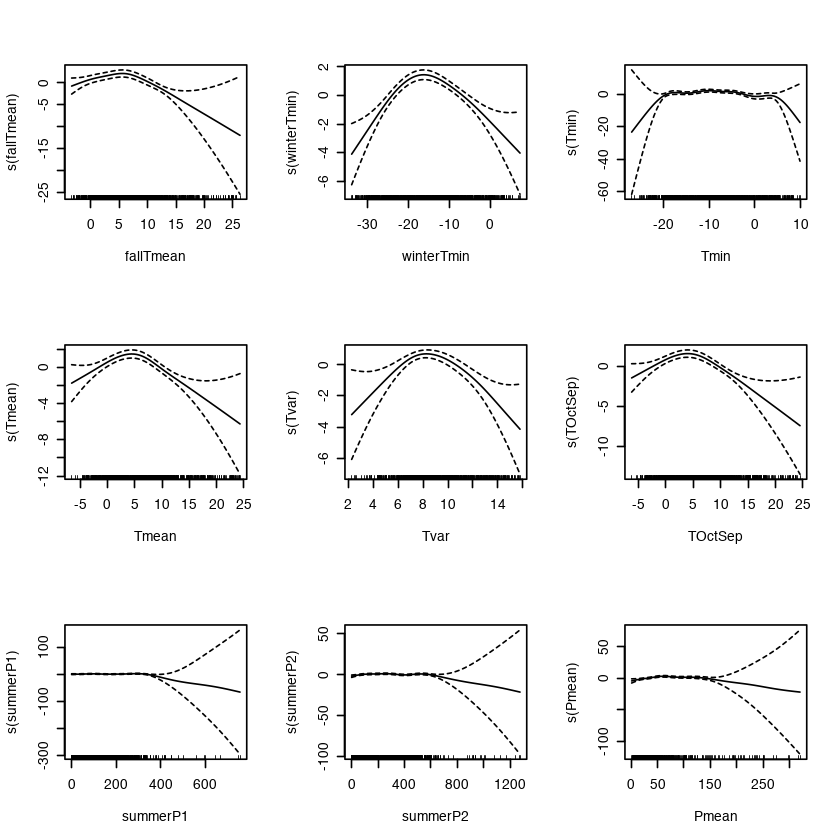

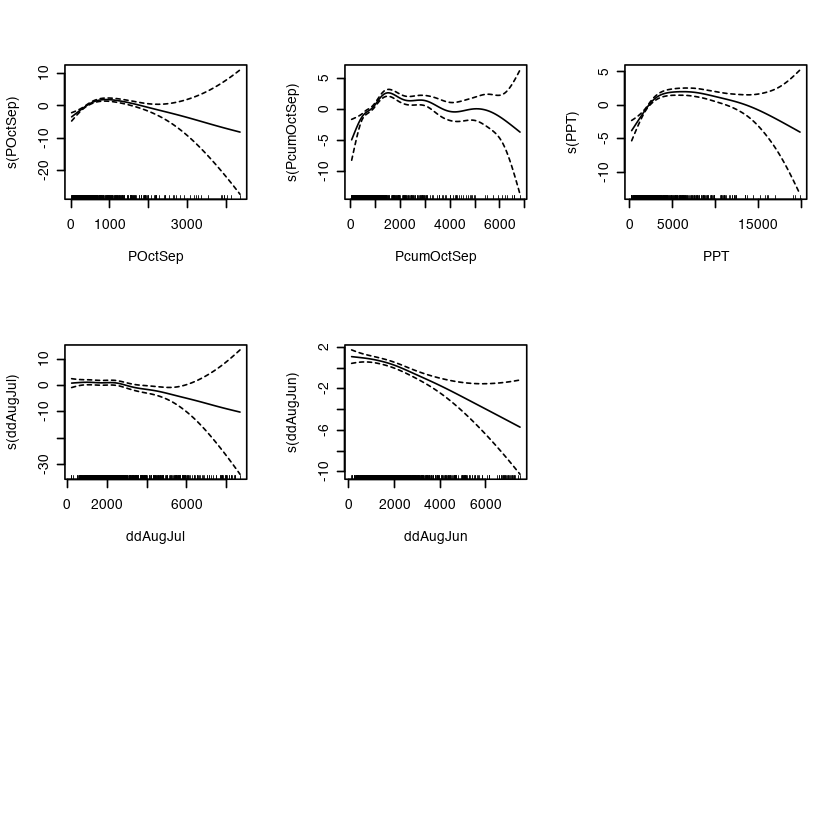

In [12]:
par(mfrow=c(3, 3))
for (field in names(train)) {
  if (!(field %in% ignore)) {
    n <- 1000
    s <- sample(nrow(train), n)
    gam.mod <- gam(train$btl_t[s] ~ s(train[s, field]), family='binomial')
    plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))    
  }
}

In [13]:
names(train)

[1] "btl_t"       "x"           "y"           "lon"         "lat"        
 [6] "etopo1"      "btl_t1"      "btl_t2"      "btl_t3"      "btl_t4"     
[11] "btl_t5"      "vgt"         "sum9_t1"     "sum9_t2"     "sum9_t3"    
[16] "sum9_t4"     "sum9_t5"     "JanTmin"     "MarTmin"     "TMarAug"    
[21] "summerTmean" "AugTmean"    "AugTmax"     "GSP"         "PMarAug"    
[26] "summerP0"    "OctTmin"     "fallTmean"   "winterTmin"  "Tmin"       
[31] "Tmean"       "Tvar"        "TOctSep"     "summerP1"    "summerP2"   
[36] "Pmean"       "POctSep"     "PcumOctSep"  "PPT"         "ddAugJul"   
[41] "ddAugJun"    "year"

In [14]:
out <- data.frame(f1=c(), f2=c(), p=c())
options(warn=-1)

for (f1 in 4:(ncol(train) - 2)) {
  for (f2 in (f1 + 1):(ncol(train) - 1)) {
    mod <- glm(train$btl_t ~ train[, f1]*train[, f2], family='binomial')
    interaction.p <- summary(mod)$coef[4, 4]
    if (interaction.p < 0.001) {
      row <- data.frame(
          f1=names(train)[f1], f2=names(train)[f2], p=interaction.p) 
      out <- rbind(out, row)
    }
  }
}

options(warn=0)

In [15]:
interactions <- out[order(out$p), ]
dim(interactions)

[1] 650   3

In [16]:
head(interactions)

f1  f2          p
13 lon TMarAug     0
14 lon summerTmean 0
15 lon AugTmean    0
16 lon AugTmax     0
17 lon GSP         0
18 lon PMarAug     0

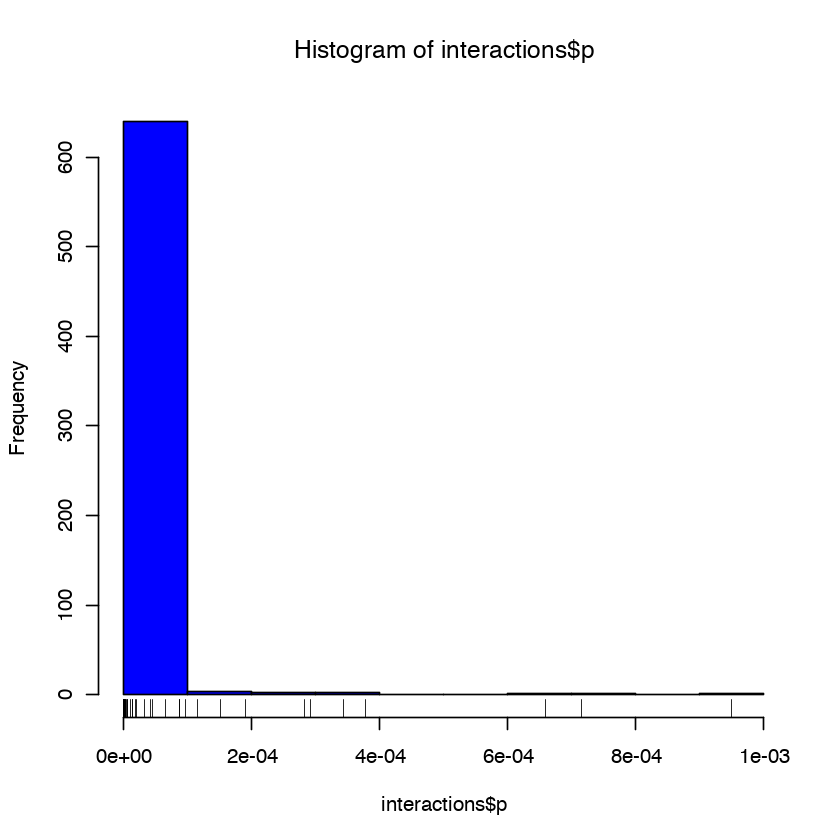

In [17]:
hist(interactions$p, col=4)
rug(interactions$p)

In [18]:
most.important <- interactions[interactions$p == 0, ]
dim(most.important)

[1] 228   3

In [19]:
head(most.important, 10)

f1  f2          p
13 lon TMarAug     0
14 lon summerTmean 0
15 lon AugTmean    0
16 lon AugTmax     0
17 lon GSP         0
18 lon PMarAug     0
25 lon Tvar        0
29 lon Pmean       0
30 lon POctSep     0
31 lon PcumOctSep  0

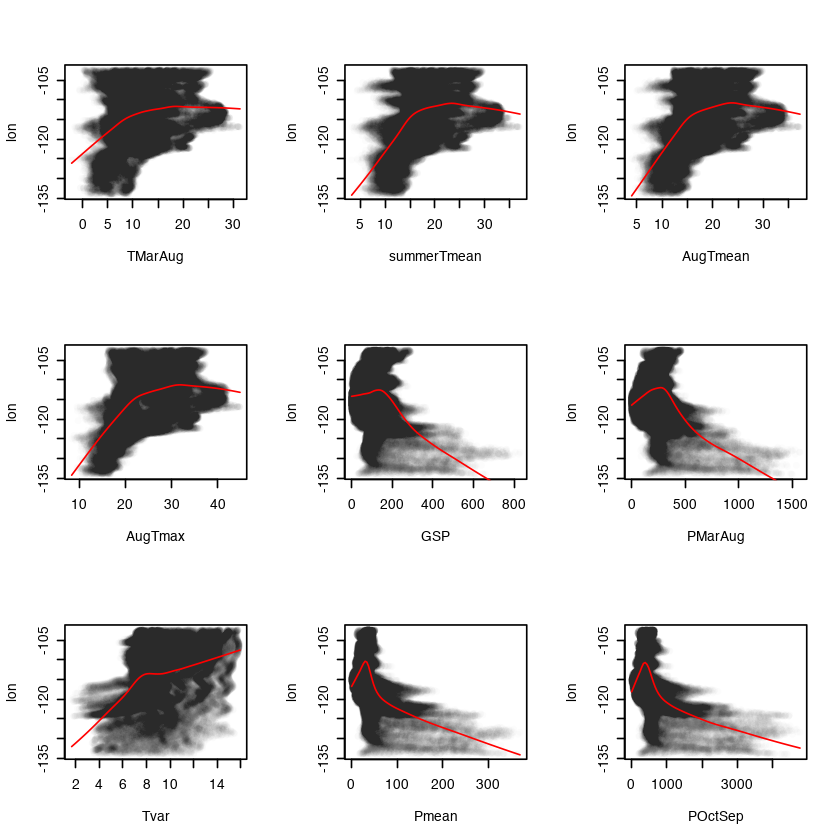

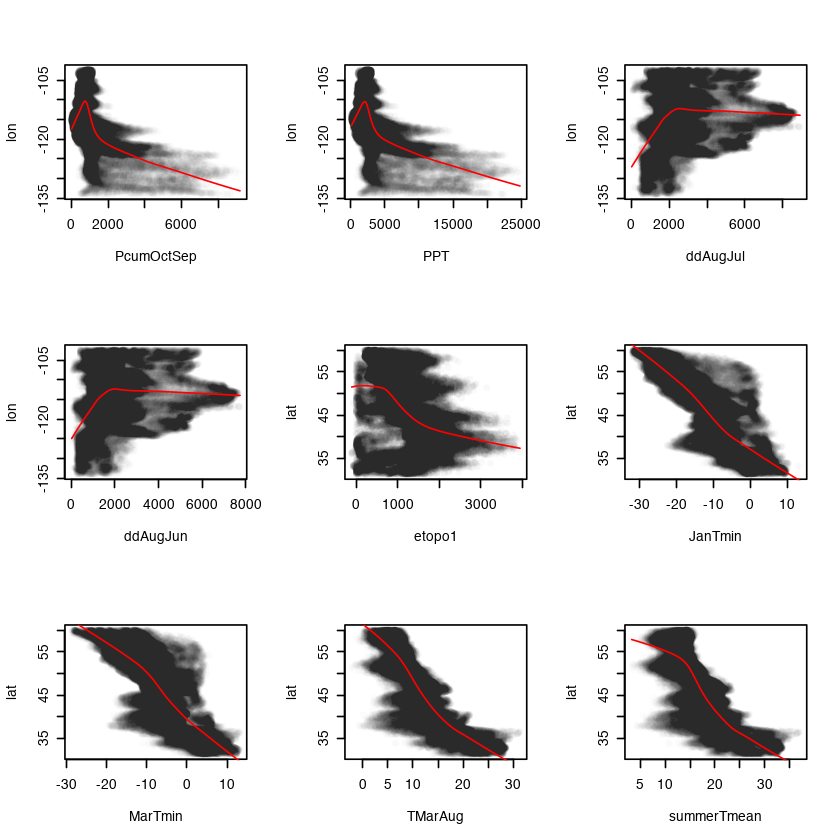

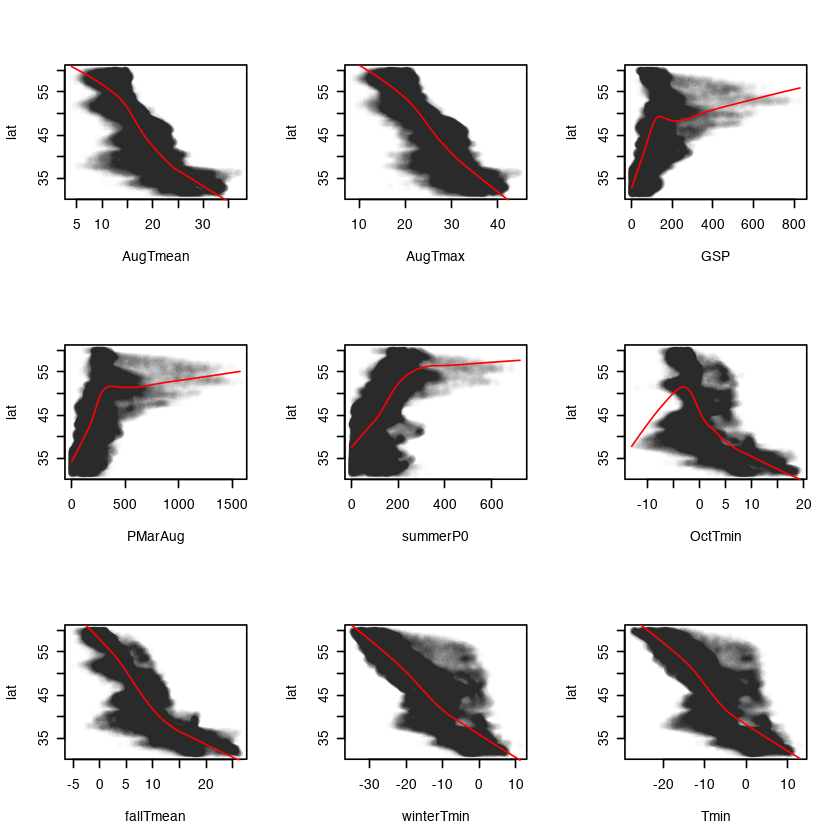

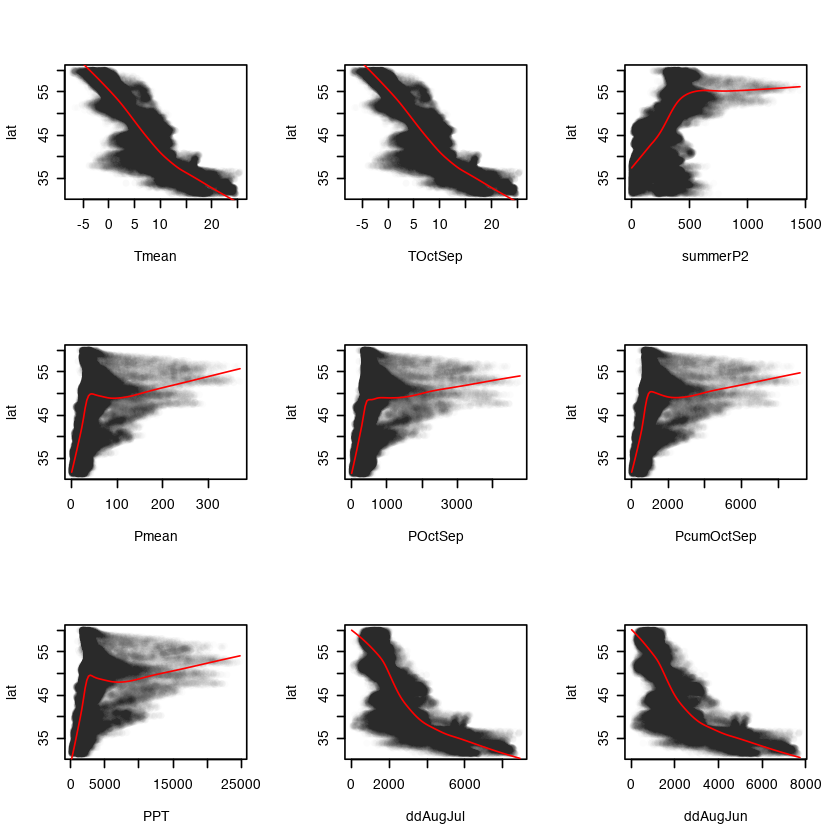

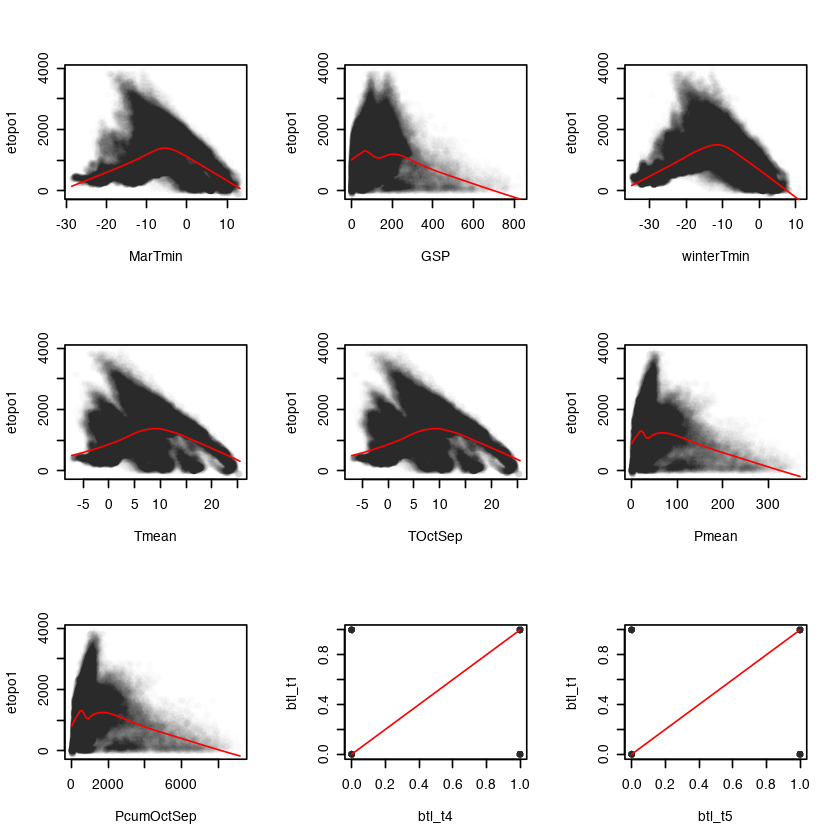

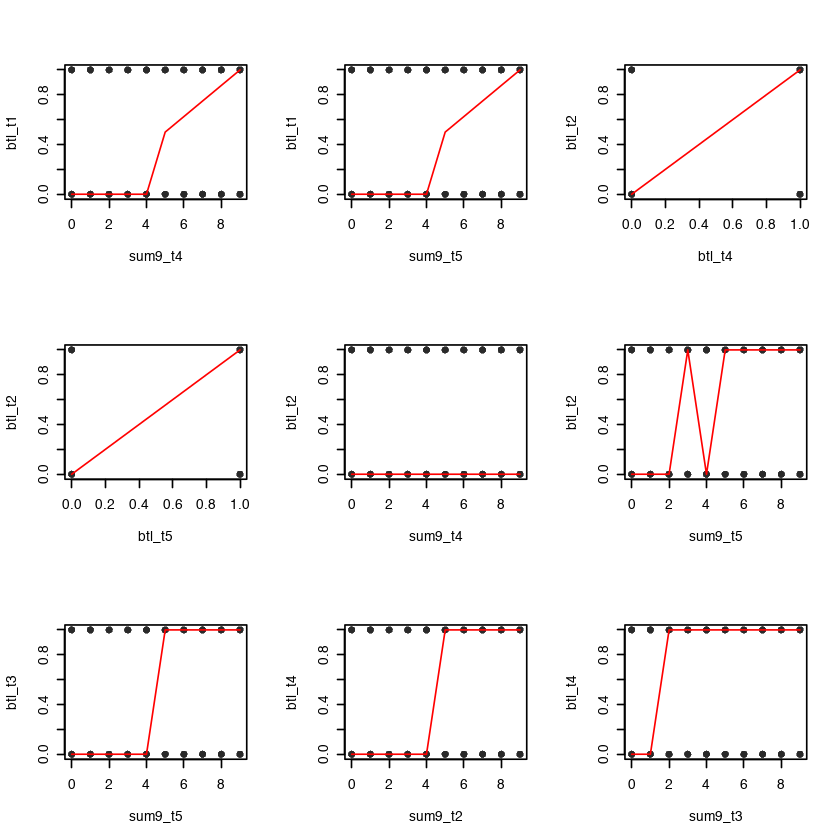

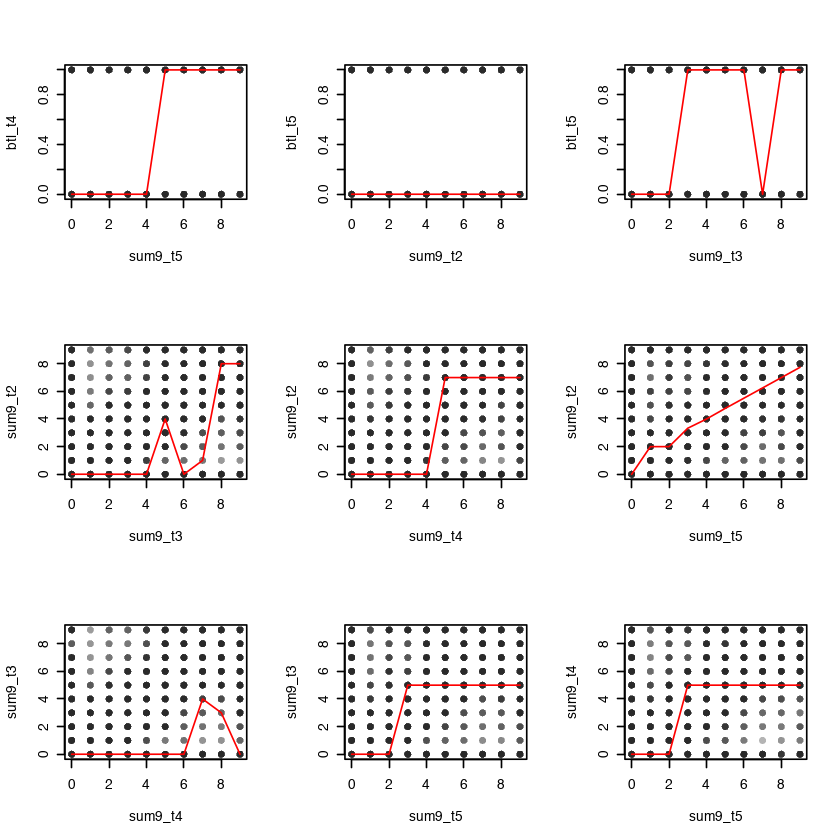

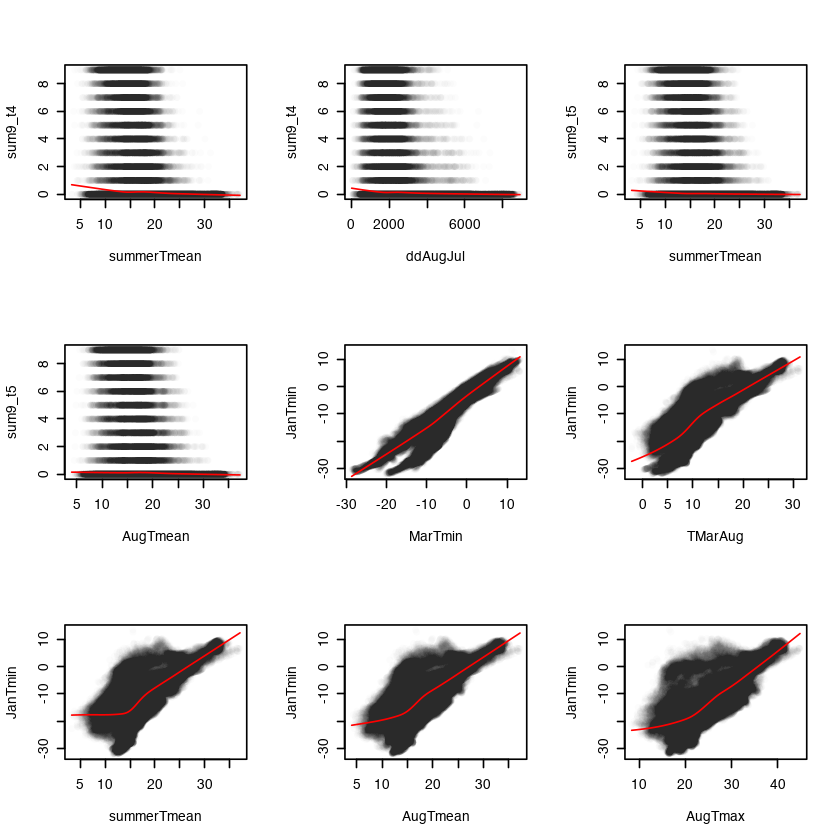

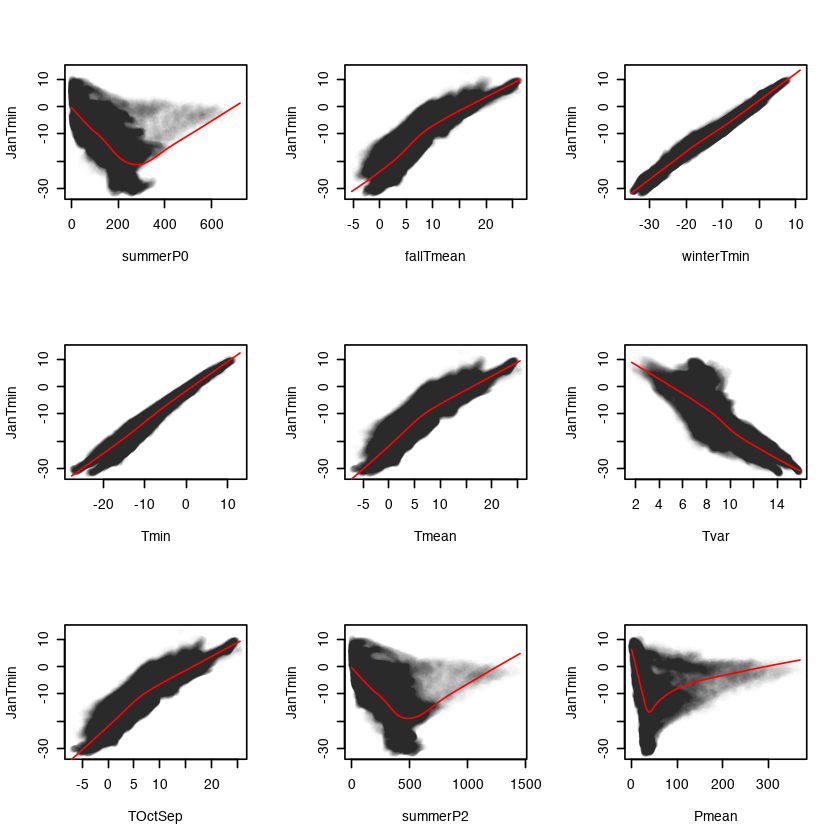

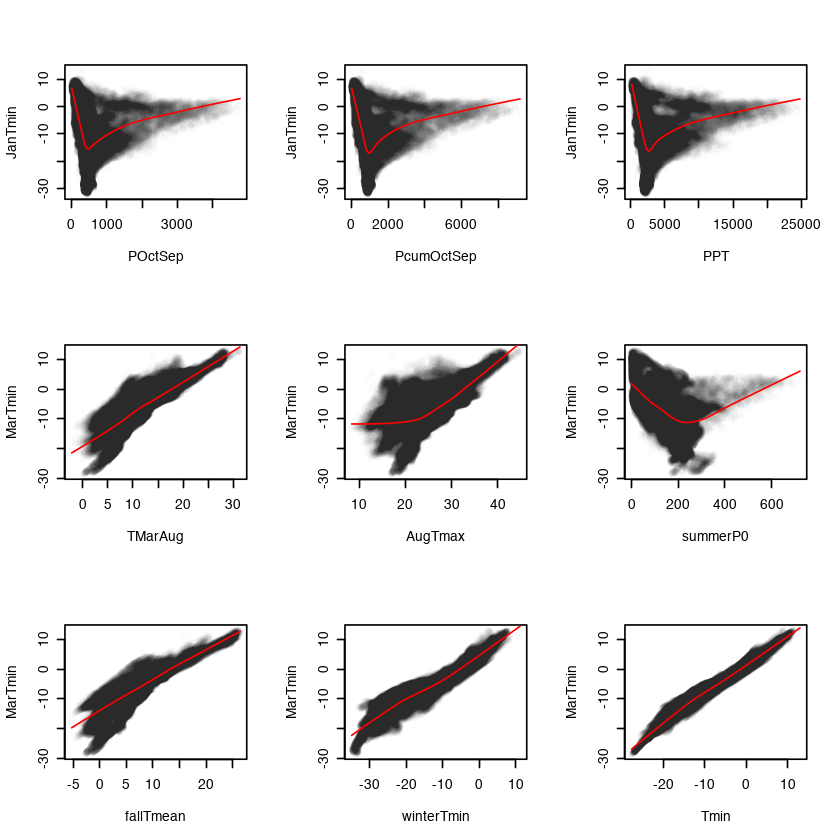

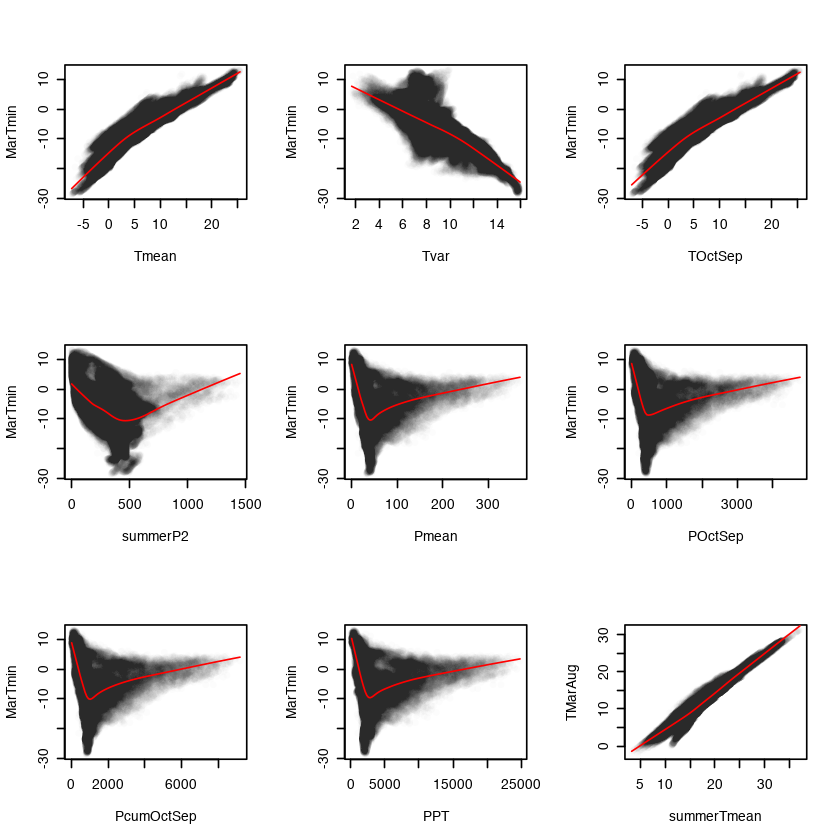

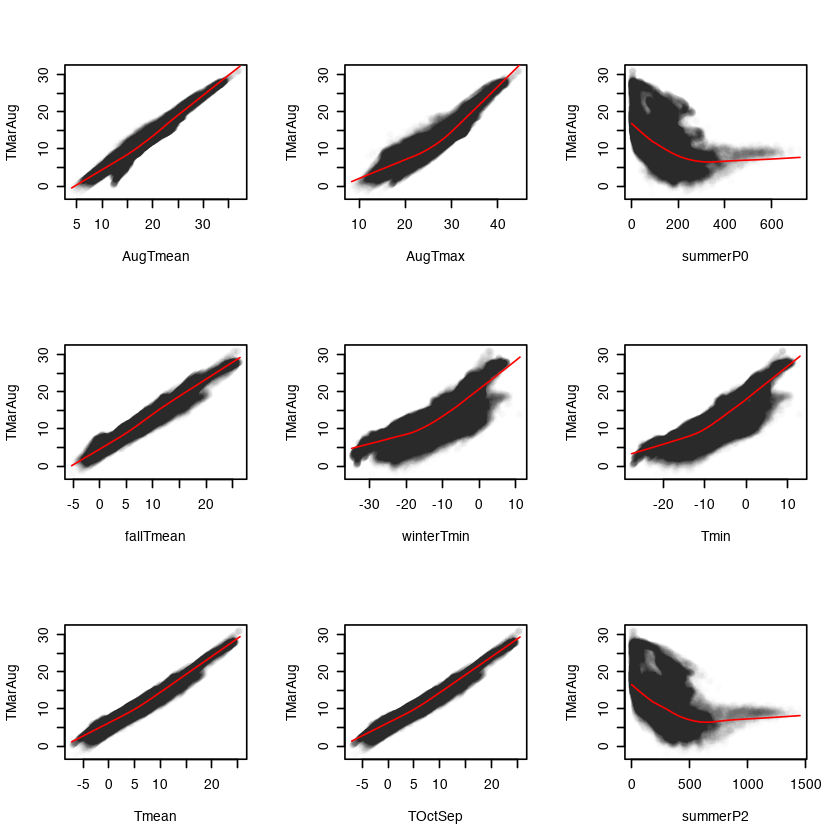

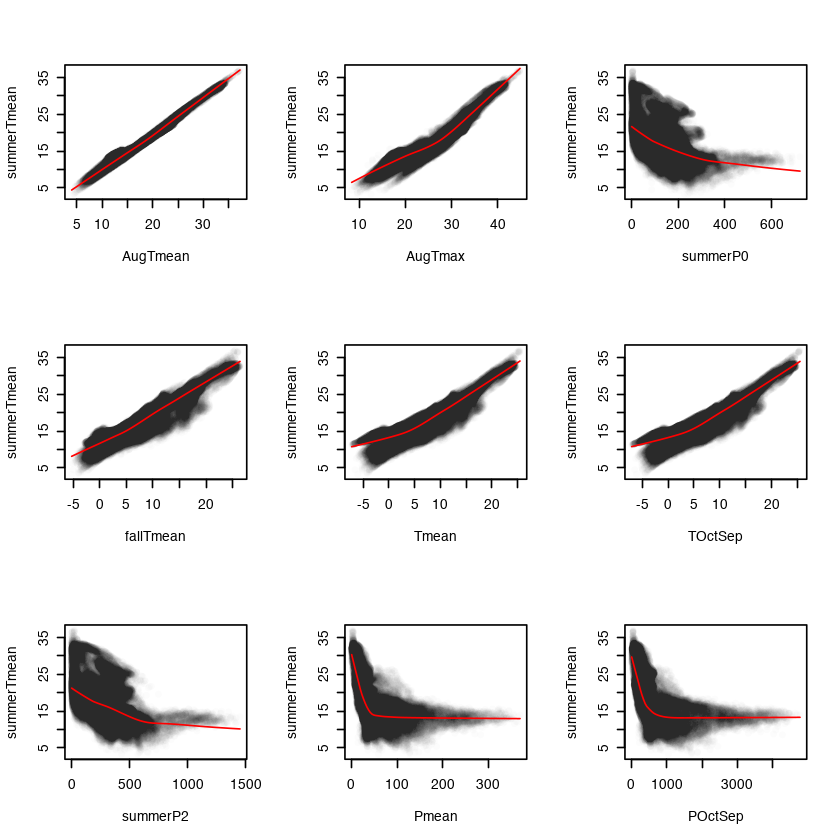

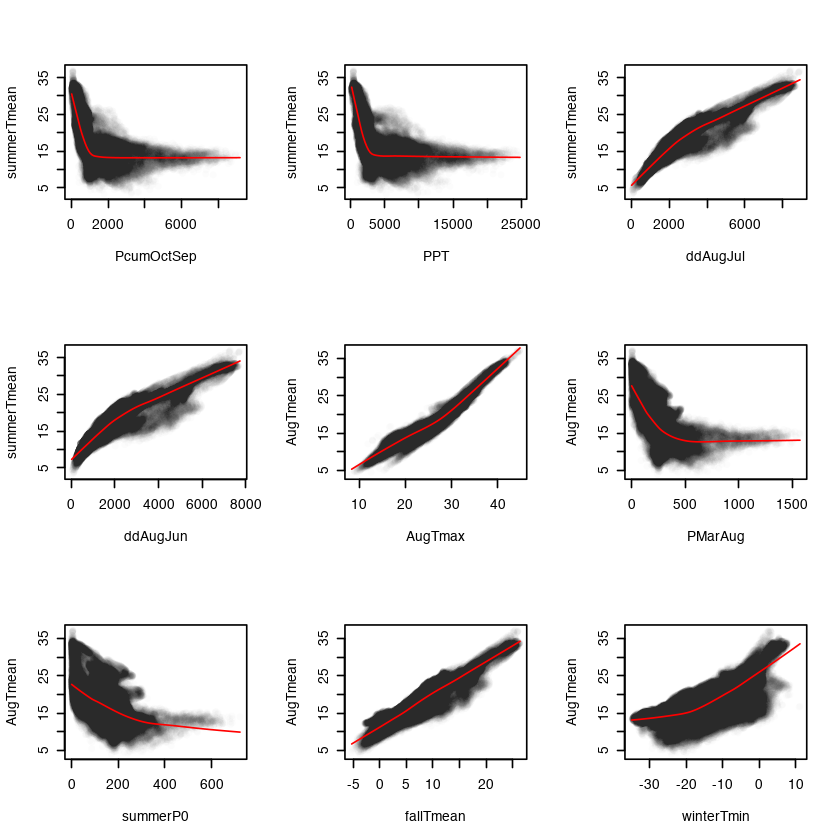

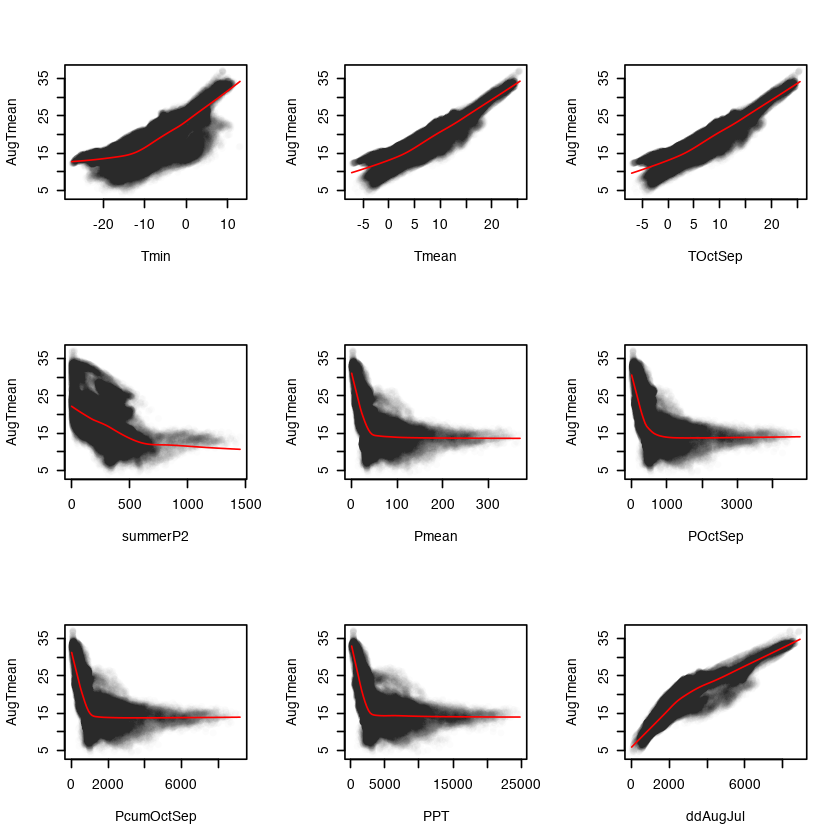

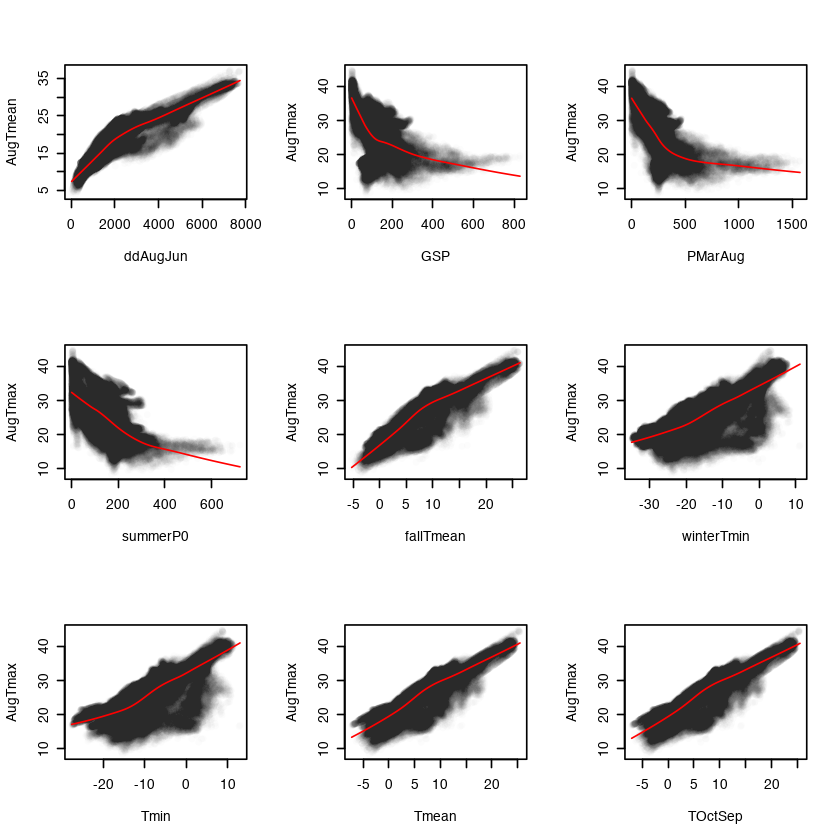

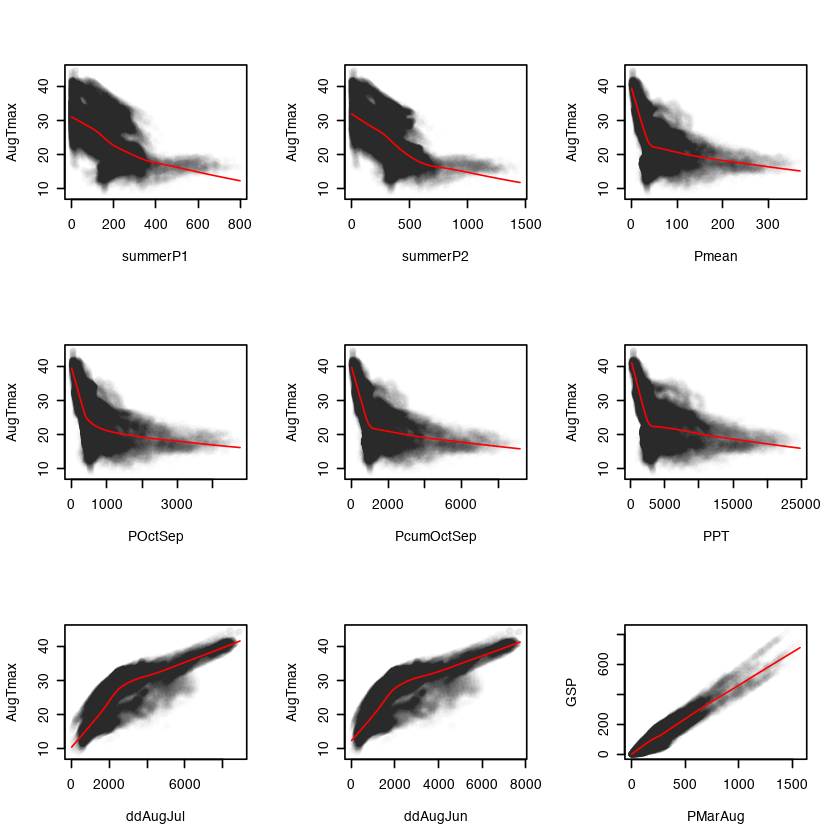

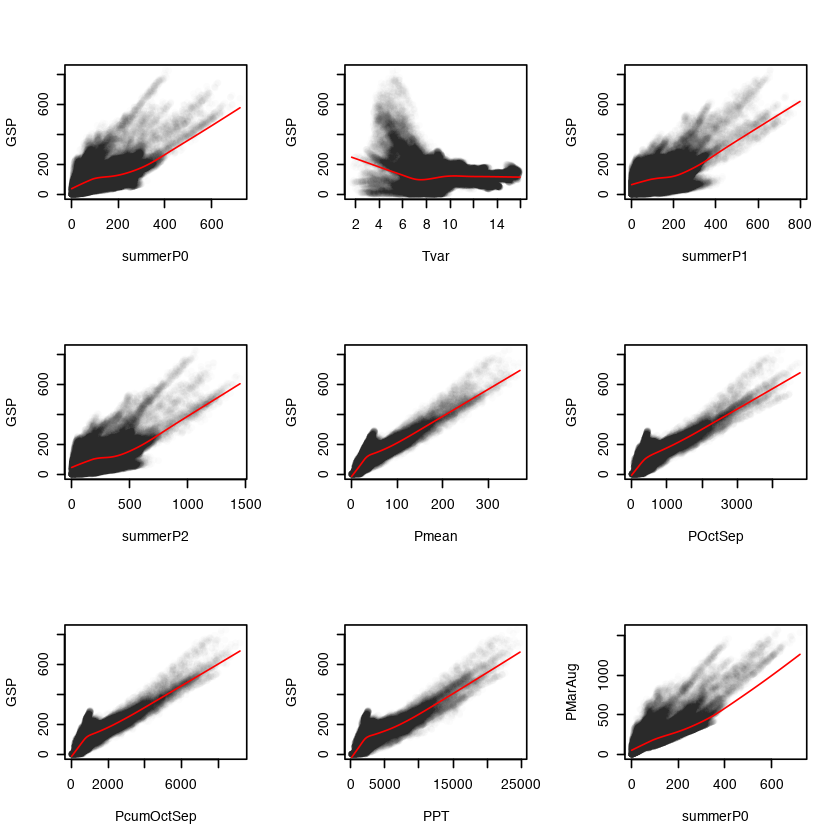

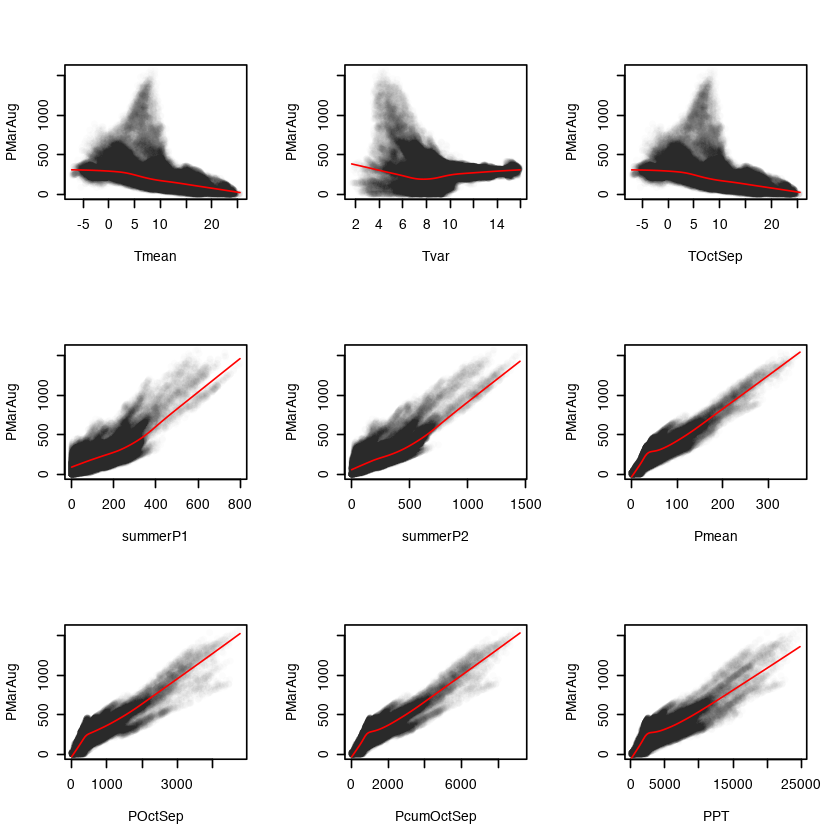

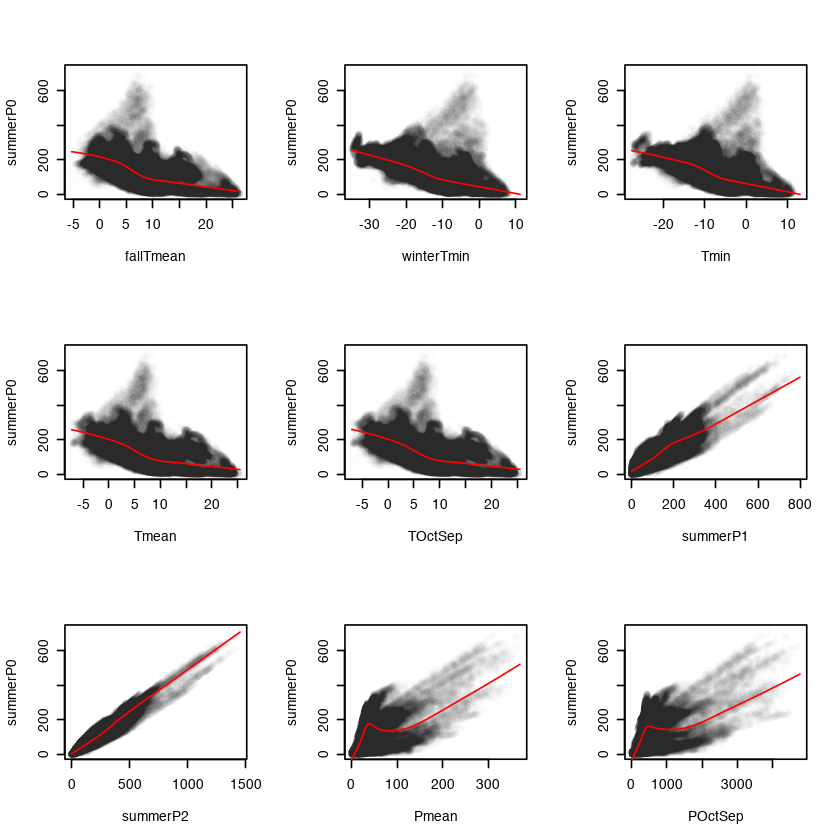

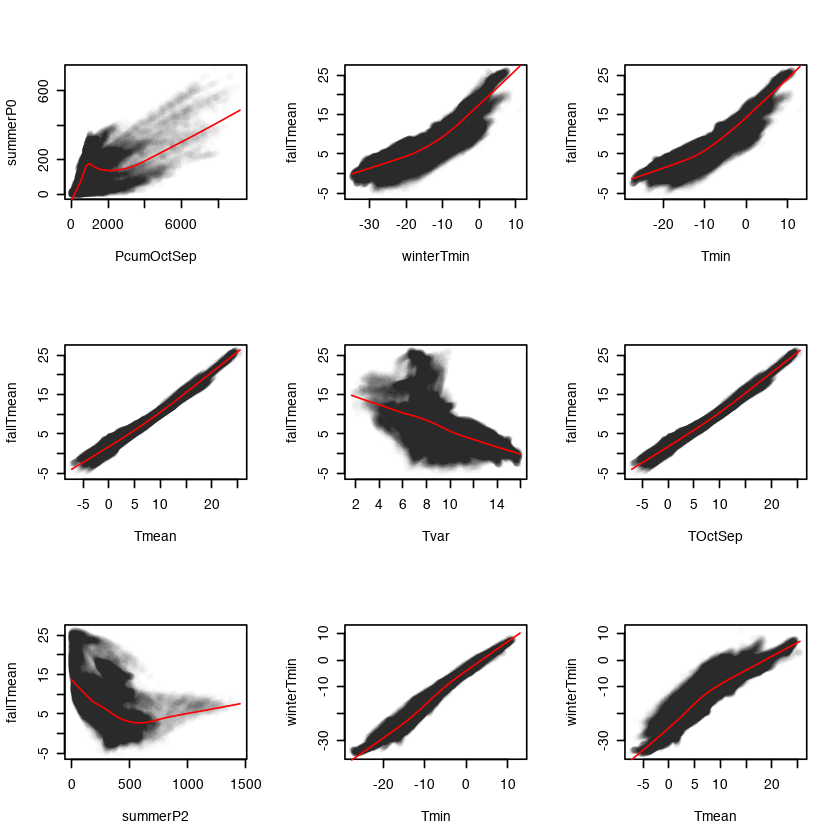

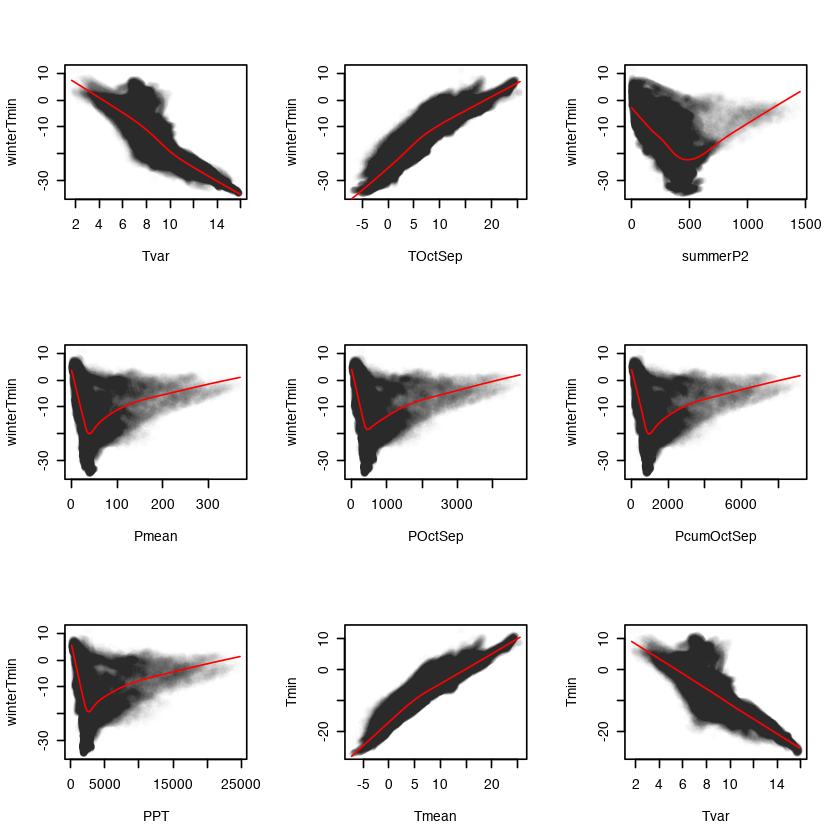

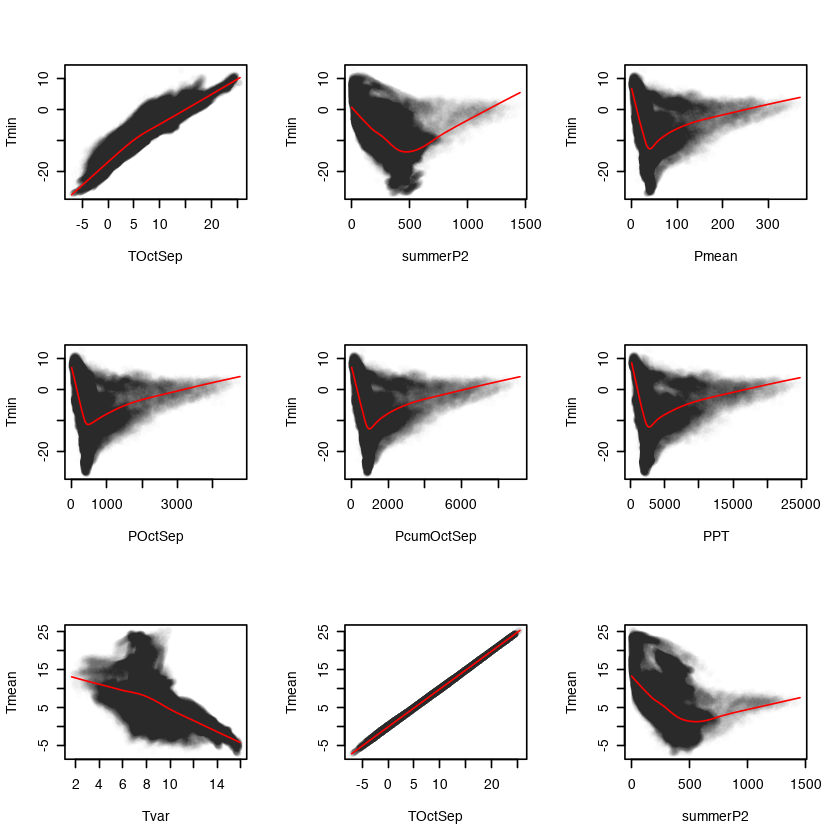

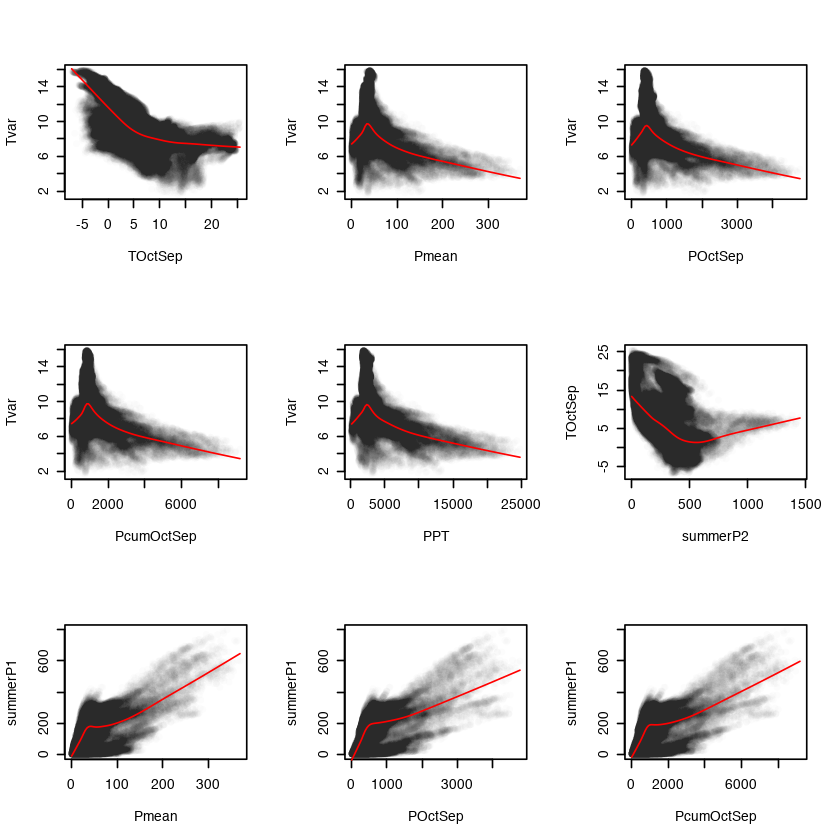

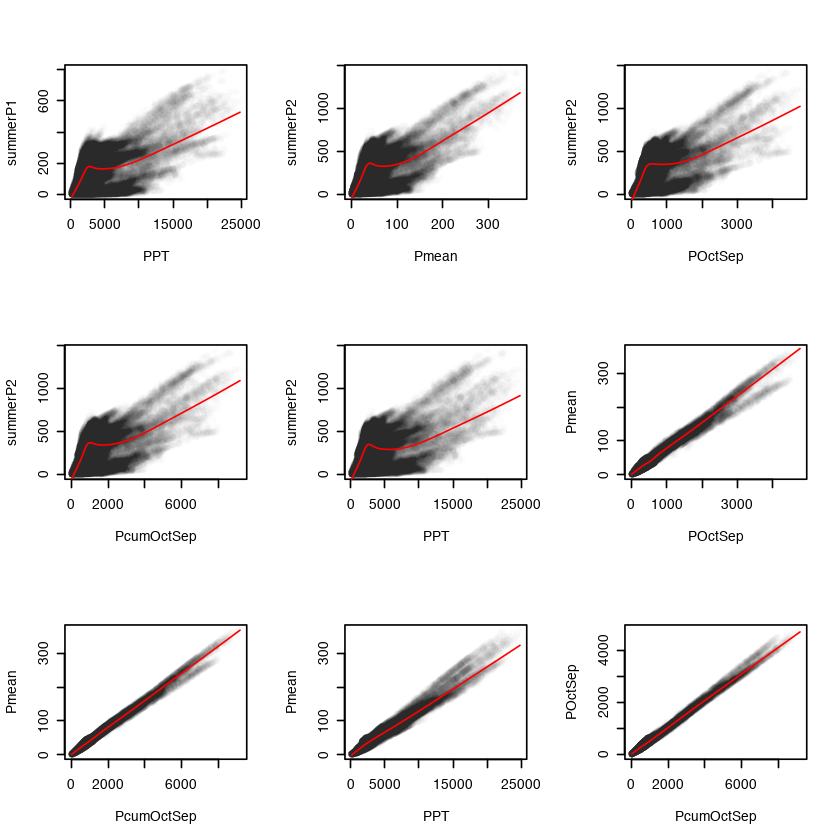

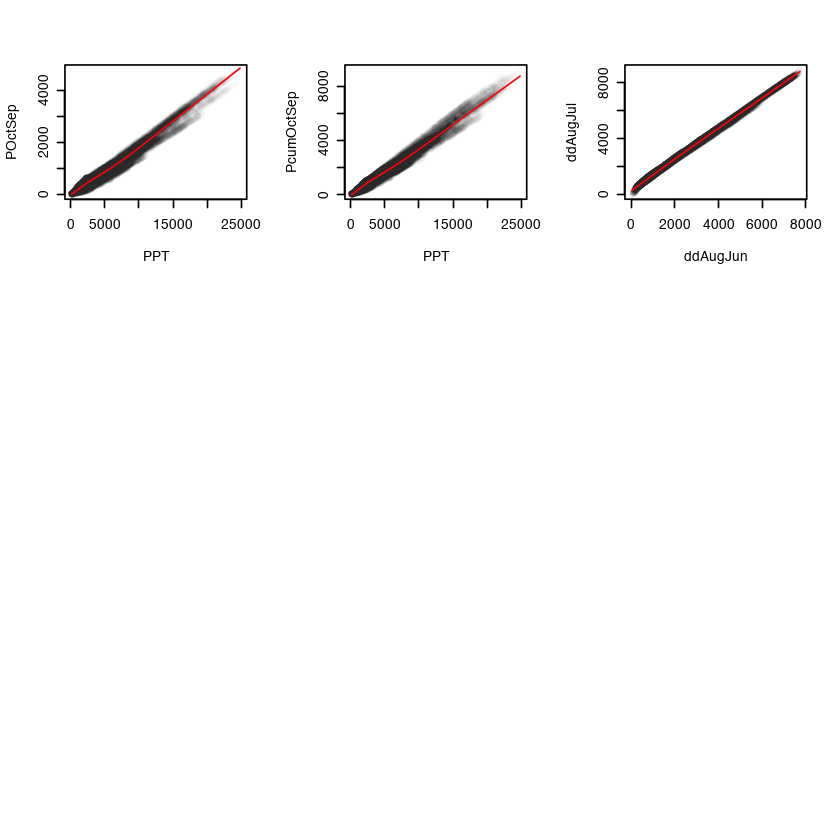

In [20]:
par(mfrow=c(3, 3))
for (i in 1:nrow(most.important)) {
  f1 <- as.character(most.important[i, 1])
  f2 <- as.character(most.important[i, 2])
  has.data <- !(is.na(train[, f1]) | is.na(train[, f2]))
  plot(train[has.data, f1] ~ train[has.data, f2], 
       pch=16, 
       col=rgb(0, 0, 0, 0.01),
       ylab=f1,
       xlab=f2)
  lines(lowess(train[has.data, f1] ~ train[has.data, f2]), col=2)
}

In [21]:
for (i in 1:nrow(most.important)) {
  cat(sprintf("'%s:%s', ", most.important[i, 'f1'], most.important[i, 'f2']))
}

'lon:TMarAug', 'lon:summerTmean', 'lon:AugTmean', 'lon:AugTmax', 'lon:GSP', 'lon:PMarAug', 'lon:Tvar', 'lon:Pmean', 'lon:POctSep', 'lon:PcumOctSep', 'lon:PPT', 'lon:ddAugJul', 'lon:ddAugJun', 'lat:etopo1', 'lat:JanTmin', 'lat:MarTmin', 'lat:TMarAug', 'lat:summerTmean', 'lat:AugTmean', 'lat:AugTmax', 'lat:GSP', 'lat:PMarAug', 'lat:summerP0', 'lat:OctTmin', 'lat:fallTmean', 'lat:winterTmin', 'lat:Tmin', 'lat:Tmean', 'lat:TOctSep', 'lat:summerP2', 'lat:Pmean', 'lat:POctSep', 'lat:PcumOctSep', 'lat:PPT', 'lat:ddAugJul', 'lat:ddAugJun', 'etopo1:MarTmin', 'etopo1:GSP', 'etopo1:winterTmin', 'etopo1:Tmean', 'etopo1:TOctSep', 'etopo1:Pmean', 'etopo1:PcumOctSep', 'btl_t1:btl_t4', 'btl_t1:btl_t5', 'btl_t1:sum9_t4', 'btl_t1:sum9_t5', 'btl_t2:btl_t4', 'btl_t2:btl_t5', 'btl_t2:sum9_t4', 'btl_t2:sum9_t5', 'btl_t3:sum9_t5', 'btl_t4:sum9_t2', 'btl_t4:sum9_t3', 'btl_t4:sum9_t5', 'btl_t5:sum9_t2', 'btl_t5:sum9_t3', 'sum9_t2:sum9_t3', 'sum9_t2:sum9_t4', 'sum9_t2:sum9_t5', 'sum9_t3:sum9_t4', 'sum9_t3:sum9_